In [1]:
# %pip install -q transformers imagecorruptions pytorch-ignite neptune sentencepiece evaluate jiwer

In [2]:
# CODE_PATH = "/content/drive/MyDrive/Mestrado/Dev/devcodes/deberta"
CODE_PATH = "../trainer"

In [3]:
import sys
sys.path.append(CODE_PATH)

In [4]:
import os
from functools import partial

import torch
import torchvision as tv
from transformers import AutoTokenizer

from ignite.engine import (
    Engine,
    Events,
)
from ignite.handlers import Checkpoint
from ignite.contrib.handlers import global_step_from_engine
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.neptune_logger import NeptuneLogger

/home/israel/Mestrado/mscenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datamodule import SVTDataModule
from model import  OCRModel, AbstractCNN
from ctc import GreedyDecoder
from igmetrics import ExactMatch, WordF1, CER

In [6]:
tokenizer = AutoTokenizer.from_pretrained(f"{CODE_PATH}/svt-tokenizers/tokenizer-pad0")
decoder = GreedyDecoder(tokenizer.pad_token_id)

In [7]:
tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.vocab_size

(1, 0, 32)

In [8]:
if tokenizer.eos_token_id is None:
    tokenizer.eos_token = tokenizer.sep_token
    tokenizer.eos_token_id = tokenizer.sep_token_id

In [9]:
tokenizer.eos_token, tokenizer.eos_token_id

('</s>', 1)

# Loader

In [10]:
DATA_PATH = "../data/SVT/"
POOLER_MODE = "mine" 

In [11]:
# !unzip {DATA_PATH}/data.zip

In [70]:
dm = SVTDataModule(
    root_dir="../data/SVT/",
    label_file=os.path.join(DATA_PATH, "train.json"),
    tokenizer=tokenizer,
    height=32,
    num_workers=4,
    train_bs=2,
    valid_bs=2,
    val_pct=0.01,
    max_width=None,
    do_pool=False,
    pooler_mode=POOLER_MODE
)

In [71]:
dm.setup("fit")

# Model

In [45]:
from torch import nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class Feature2Embedding(nn.Module):
    def forward(self, x):
        n, c, h, w = x.shape
        assert h == 1, "the height of out must be 1"
        x = x.squeeze(2) # [n, c, w]
        return x.permute(0, 2, 1)#.reshape(n, -1, c)

class CNNSmallDropout(nn.Module):
    """
    Custom CNN
    """

    def __init__(
        self,
        vocab_size: int = 100,
        p: float = 0.15,
    ):
        super().__init__()

        self.image_embeddings = nn.Sequential(
            self.block(3, 64, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(64, 128, st=(2, 2)),
            nn.Dropout2d(p),
            self.block(128, 256, st=(2, 1)),
            nn.Dropout2d(p),
            self.block(256, 512, st=(4, 1)),
            nn.Dropout2d(p),
            Feature2Embedding(),
        )
        self.lm_head = nn.Linear(512, vocab_size)

    def block(self, in_channels, out_channels, st=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=st, padding=1),
            nn.BatchNorm2d(out_channels),
            Swish(),
        )

    def forward(self, images, *args, **kwargs):
        embedding = self.image_embeddings(images)
        return embedding

    def lm(self, embedding):
        return self.lm_head(embedding)

In [46]:
from transformers import DebertaV2ForTokenClassification, DebertaV2Config

class AbstractTransformersEncoder(torch.nn.Module):
    def __init__(self, vocab_size: int = 100, config_dict: dict = {}):
        super().__init__()
        self.vocab_size = vocab_size
        config_dict = self._get_config_dict(config_dict)
        config = DebertaV2Config(**config_dict)
        self.encoder = DebertaV2ForTokenClassification(config)

    def _get_config_dict(self, config_dict):
        base_config_dict = {
            "model_type": "deberta-v2",
            "architectures": ["DebertaV2ForTokenClassification"],
            "num_labels": self.vocab_size,
            "model_type": "deberta-v2",
            "attention_probs_dropout_prob": 0.0,
            "hidden_act": "gelu",
            "hidden_dropout_prob": 0.0,
            "hidden_size": 512,
            "initializer_range": 0.02,
            "intermediate_size": 768,  # 3072,
            "max_position_embeddings": 512,
            "relative_attention": True,
            "position_buckets": 64,  # TODO: Maybe less?
            "norm_rel_ebd": "layer_norm",
            "share_att_key": True,
            "pos_att_type": "p2c|c2p",
            "layer_norm_eps": 1e-7,
            "max_relative_positions": -1,
            "position_biased_input": True,
            "num_attention_heads": 8,
            "num_hidden_layers": 3,
            "type_vocab_size": 0,
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
            "vocab_size": self.vocab_size,
        }
        base_config_dict.update(config_dict)
        return base_config_dict

    def forward(self, image_embeddings, attention_mask=None):
        outputs = self.encoder(
            inputs_embeds=image_embeddings, attention_mask=attention_mask
        )
        return outputs.logits

In [47]:
vis_model = CNNSmallDropout(vocab_size=tokenizer.vocab_size)
rec_model = AbstractTransformersEncoder(vocab_size=tokenizer.vocab_size)
model = OCRModel(vis_model, rec_model)

In [48]:
_ = model.to("cpu")

In [49]:
batch = next(iter(dm.val_dataloader()))
with torch.no_grad():
    images, labels, attention_mask, attention_image = batch
    logits = model(images)
logits.shape

torch.Size([2, 18, 32])

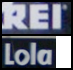

In [50]:
# display images using torchvision utils make_grid
grid = tv.utils.make_grid(images, nrow=1)
tv.transforms.ToPILImage()(grid)

In [51]:
attention_mask.sum(-1)

tensor([4, 5])

In [52]:
labels

tensor([[14,  9, 28,  1,  0],
        [25, 27, 25, 13,  1]])

In [53]:
tokenizer.batch_decode(labels, skip_special_tokens=False)

['REI</s><pad>', 'LOLA</s>']

In [54]:
logits.argmax(-1)

tensor([[28,  2, 28, 30, 28, 18, 24,  7, 21, 10, 21,  5, 24, 28, 29,  1, 14,  2],
        [28, 27, 21, 20,  8, 12, 22, 15, 28,  8, 15, 22, 29,  3,  1, 25,  1, 19]])

# Ignite

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
_ = model.to(device)

In [57]:
val_loader = dm.val_dataloader()
train_loader = val_loader #dm.train_dataloader()

In [58]:
MAX_EPOCHS=30

In [59]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
criterion = torch.nn.CTCLoss(blank=tokenizer.pad_token_id, zero_infinity=True)

In [60]:
def get_preds_from_logits(logits, labels):
    decoded_ids = logits.argmax(-1).squeeze(0)
    if len(decoded_ids.shape) == 1:
        decoded_ids = decoded_ids.unsqueeze(0)
    decoded = [
        decoder(dec, None) for dec in decoded_ids
    ]
    y_pred = tokenizer.batch_decode(decoded, skip_special_tokens=True)
    y = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return y_pred, y

In [61]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    images, labels, labels_mask = [x.to(device) for x in batch[:-1]]

    logits = model(images)

    logits = logits.permute(1, 0, 2).log_softmax(2)
    input_lengths = torch.full(
        size=(logits.size(1),),
        fill_value=logits.size(0),
        dtype=torch.int32,
    )
    target_lengths = labels_mask.sum(-1)

    loss = criterion(logits, labels, input_lengths, target_lengths)
    loss.backward()
    
    optimizer.step()
    return loss.item()

In [62]:
def val_step(engine, batch):
    model.eval()
    images, labels = [x.to(device) for x in batch[:-2]]
    with torch.no_grad():
        logits = model(images, None)

    y_pred, y = get_preds_from_logits(logits, labels)
    return y_pred, y
    

In [63]:
def log_validation_results(engine):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f}")

In [64]:
trainer = Engine(train_step)
validation_evaluator = Engine(val_step)

In [65]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

ExactMatch().attach(validation_evaluator, "accuracy")

In [66]:
pbar = ProgressBar()
pbar.attach(trainer, output_transform=lambda x: {'loss': x})

In [67]:
trainer.run(train_loader, max_epochs=100)

Validation Results - Epoch: 1  Avg accuracy: 0.000


Validation Results - Epoch: 2  Avg accuracy: 0.000


Validation Results - Epoch: 3  Avg accuracy: 0.000


Validation Results - Epoch: 4  Avg accuracy: 0.000


Validation Results - Epoch: 5  Avg accuracy: 0.000


Validation Results - Epoch: 6  Avg accuracy: 0.000


Validation Results - Epoch: 7  Avg accuracy: 0.000


Validation Results - Epoch: 8  Avg accuracy: 0.000


Validation Results - Epoch: 9  Avg accuracy: 0.000


Validation Results - Epoch: 10  Avg accuracy: 0.000


Validation Results - Epoch: 11  Avg accuracy: 0.000


Validation Results - Epoch: 12  Avg accuracy: 0.000


Validation Results - Epoch: 13  Avg accuracy: 0.000


Validation Results - Epoch: 14  Avg accuracy: 0.000


Validation Results - Epoch: 15  Avg accuracy: 0.000


Validation Results - Epoch: 16  Avg accuracy: 0.000


Validation Results - Epoch: 17  Avg accuracy: 0.000


Validation Results - Epoch: 18  Avg accuracy: 0.000


Validation Results - Epoch: 19  Avg accuracy: 0.000


Validation Results - Epoch: 20  Avg accuracy: 0.000


Validation Results - Epoch: 21  Avg accuracy: 0.000


Validation Results - Epoch: 22  Avg accuracy: 0.000


Validation Results - Epoch: 23  Avg accuracy: 0.000


Validation Results - Epoch: 24  Avg accuracy: 0.000


Validation Results - Epoch: 25  Avg accuracy: 0.000


Validation Results - Epoch: 26  Avg accuracy: 0.000


Validation Results - Epoch: 27  Avg accuracy: 0.000


Validation Results - Epoch: 28  Avg accuracy: 0.000


Validation Results - Epoch: 29  Avg accuracy: 0.000


Validation Results - Epoch: 30  Avg accuracy: 0.000


Validation Results - Epoch: 31  Avg accuracy: 0.500


Validation Results - Epoch: 32  Avg accuracy: 0.000


Validation Results - Epoch: 33  Avg accuracy: 0.500


Validation Results - Epoch: 34  Avg accuracy: 0.500


Validation Results - Epoch: 35  Avg accuracy: 0.500


Validation Results - Epoch: 36  Avg accuracy: 0.500


Validation Results - Epoch: 37  Avg accuracy: 0.500


Validation Results - Epoch: 38  Avg accuracy: 0.500


Validation Results - Epoch: 39  Avg accuracy: 0.500


Validation Results - Epoch: 40  Avg accuracy: 0.500


Validation Results - Epoch: 41  Avg accuracy: 0.500


Validation Results - Epoch: 42  Avg accuracy: 0.500


Validation Results - Epoch: 43  Avg accuracy: 0.500


Validation Results - Epoch: 44  Avg accuracy: 0.500


Validation Results - Epoch: 45  Avg accuracy: 0.500


Validation Results - Epoch: 46  Avg accuracy: 0.500


Validation Results - Epoch: 47  Avg accuracy: 0.500


Validation Results - Epoch: 48  Avg accuracy: 0.500


Validation Results - Epoch: 49  Avg accuracy: 0.500


Validation Results - Epoch: 50  Avg accuracy: 0.500


Validation Results - Epoch: 51  Avg accuracy: 0.500


Validation Results - Epoch: 52  Avg accuracy: 0.500


Validation Results - Epoch: 53  Avg accuracy: 0.500


Validation Results - Epoch: 54  Avg accuracy: 0.500


Validation Results - Epoch: 55  Avg accuracy: 0.500


Validation Results - Epoch: 56  Avg accuracy: 1.000


Validation Results - Epoch: 57  Avg accuracy: 1.000


Validation Results - Epoch: 58  Avg accuracy: 1.000


Validation Results - Epoch: 59  Avg accuracy: 1.000


Validation Results - Epoch: 60  Avg accuracy: 1.000


Validation Results - Epoch: 61  Avg accuracy: 1.000


Validation Results - Epoch: 62  Avg accuracy: 1.000


Validation Results - Epoch: 63  Avg accuracy: 1.000


Validation Results - Epoch: 64  Avg accuracy: 1.000


Validation Results - Epoch: 65  Avg accuracy: 1.000


Validation Results - Epoch: 66  Avg accuracy: 1.000


Validation Results - Epoch: 67  Avg accuracy: 1.000


Validation Results - Epoch: 68  Avg accuracy: 1.000


Validation Results - Epoch: 69  Avg accuracy: 1.000


Validation Results - Epoch: 70  Avg accuracy: 1.000


Validation Results - Epoch: 71  Avg accuracy: 1.000


Validation Results - Epoch: 72  Avg accuracy: 1.000


Validation Results - Epoch: 73  Avg accuracy: 1.000


Validation Results - Epoch: 74  Avg accuracy: 1.000


Validation Results - Epoch: 75  Avg accuracy: 1.000


Validation Results - Epoch: 76  Avg accuracy: 1.000


Validation Results - Epoch: 77  Avg accuracy: 1.000


Validation Results - Epoch: 78  Avg accuracy: 1.000


Validation Results - Epoch: 79  Avg accuracy: 1.000


Validation Results - Epoch: 80  Avg accuracy: 1.000


Validation Results - Epoch: 81  Avg accuracy: 1.000


Validation Results - Epoch: 82  Avg accuracy: 1.000


Validation Results - Epoch: 83  Avg accuracy: 1.000


Validation Results - Epoch: 84  Avg accuracy: 1.000


Validation Results - Epoch: 85  Avg accuracy: 1.000


Validation Results - Epoch: 86  Avg accuracy: 1.000


Validation Results - Epoch: 87  Avg accuracy: 1.000


Validation Results - Epoch: 88  Avg accuracy: 1.000


Validation Results - Epoch: 89  Avg accuracy: 1.000


Validation Results - Epoch: 90  Avg accuracy: 1.000


Validation Results - Epoch: 91  Avg accuracy: 1.000


Validation Results - Epoch: 92  Avg accuracy: 1.000


Validation Results - Epoch: 93  Avg accuracy: 1.000


Validation Results - Epoch: 94  Avg accuracy: 1.000


Validation Results - Epoch: 95  Avg accuracy: 1.000


Validation Results - Epoch: 96  Avg accuracy: 1.000


Validation Results - Epoch: 97  Avg accuracy: 1.000


Validation Results - Epoch: 98  Avg accuracy: 1.000


Validation Results - Epoch: 99  Avg accuracy: 1.000


Validation Results - Epoch: 100  Avg accuracy: 1.000


State:
	iteration: 100
	epoch: 100
	epoch_length: 1
	max_epochs: 100
	output: 0.017785176634788513
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [36]:
batch = next(iter(dm.val_dataloader()))

In [37]:
for _ in range(100):
    loss = train_step(None, batch)
    print(loss)

0.08251670002937317
0.08130654692649841
0.08013612031936646
0.07900286465883255
0.0779040977358818
0.07683774828910828
0.07580184936523438
0.07479488849639893


KeyboardInterrupt: 

In [68]:
y_pred, y = val_step(None, batch)

In [69]:
y_pred, y

(['REI', 'LOLA'], ['REI', 'LOLA'])